In [1]:
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
# from sklearn.externals import joblib
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, KFold
import warnings
import torch.nn as nn
import torch
from utils import *
from scipy.stats import norm
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
asin = 'B07FKN76ZS'
train = data[data.asin == asin][[
    'data_date', 'ordered_units']].sort_values('data_date')

train.shape

(621, 2)

In [4]:
train.head(3)

,data_date,ordered_units
15970,2019-12-02,2667
15932,2019-12-03,684
15898,2019-12-04,631


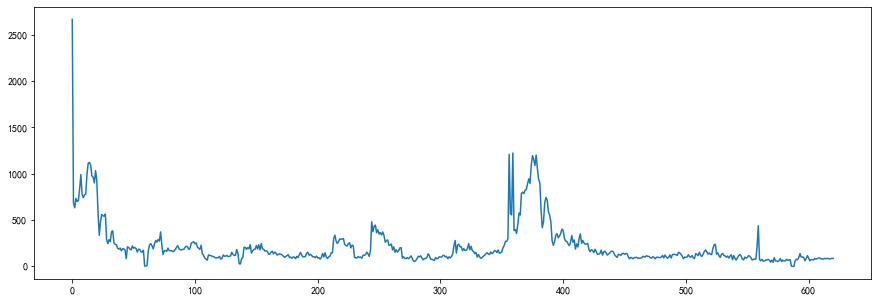

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(train.ordered_units.values)

## ordered_units

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

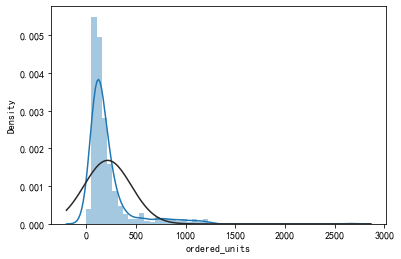

In [6]:
sns.distplot(train.ordered_units, kde=True, fit=norm)

In [7]:
train.ordered_units.skew()

3.7904860504893128

In [8]:
adfuller(train.ordered_units)

(-3.544474828500007,
 0.0069157078422445875,
 7,
 613,
 {'1%': -3.4410627157395908,
  '5%': -2.8662664495424255,
  '10%': -2.5692871001333266},
 6871.303173995818)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [9]:
train[train.ordered_units <= 0].index

Int64Index([13938, 26858, 26919, 26979], dtype='int64')

In [10]:
train.drop(train[train.ordered_units <= 0].index, inplace=True)

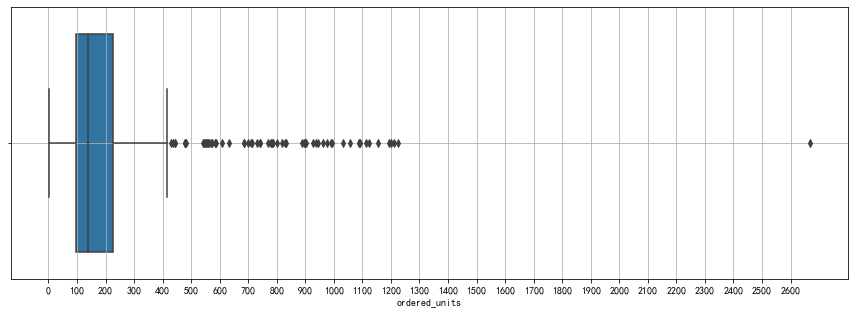

In [11]:
plt.figure(figsize=(15, 5))
plt.xticks(np.arange(0, 2700, 100))
sns.boxplot(x=train.ordered_units)
plt.grid()

In [12]:
train[train.ordered_units > 1500].index

Int64Index([15970], dtype='int64')

In [13]:
train.drop(train[train.ordered_units > 1500].index, inplace=True)

In [14]:
train.shape

(616, 2)

### 数据转换

In [15]:
train.ordered_units.skew(), np.log(train.ordered_units).skew()

(2.7152973423713944, 0.22460467778877624)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

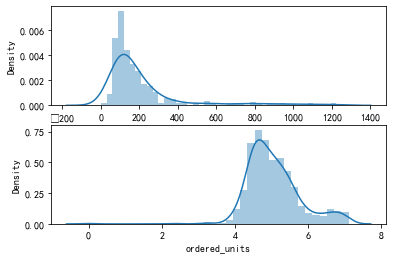

In [16]:
plt.subplot(2, 1, 1)
sns.distplot(train.ordered_units)
plt.subplot(2, 1, 2)
sns.distplot(np.log(train.ordered_units))

In [17]:
log_transform = False
if log_transform:
    train.ordered_units = np.log(train.ordered_units)

### 缺失值

In [18]:
train.isnull().sum()

data_date        0
ordered_units    0
dtype: int64

无缺失值不用处理

### 创造特征

In [19]:
def create_feature(df1):
    df = df1.copy()
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear
    df['weight'] = df.data_date.apply(lambda x: (
        x - pd.to_datetime('2019-12-02')).days)
    df['dayofyear'] = df.data_date.dt.day_of_year
    df = df.set_index('data_date')

#     df.drop('data_date', axis=1, inplace=True)
    return df

In [20]:
train_featured = create_feature(train)

In [21]:
train_featured.head(1)

,ordered_units,year,month,day,weekday,quarter,weekofyear,weight,dayofyear
data_date,,,,,,,,,
2019-12-03,684,2019,12,3,1,4,49,1,337


In [22]:
train_featured.shape

(616, 9)

## 划分数据集

In [19]:
def split_dataset(alldata, test_size, shuffle, encoder=None, is_encode=False):

    x_train, x_test, y_train, y_test = train_test_split(alldata.drop(
        'ordered_units', axis=1), alldata.ordered_units, test_size=test_size, shuffle=shuffle)

    if is_encode:
        x_train_np = encoder.fit_transform(x_train)
        x_train_pd = pd.DataFrame(
            x_train_np, index=x_train.index, columns=encoder.get_feature_names())
        x_test_np = encoder.transform(x_test)
        x_test_pd = pd.DataFrame(
            x_test_np, index=x_test.index, columns=encoder.get_feature_names())
        return x_train_pd, x_test_pd, y_train, y_test

    return x_train, x_test, y_train, y_test

In [20]:
# 可以限制日期。
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
x_train, x_valid, y_train, y_valid = split_dataset(
    train_featured, test_size=0.096, shuffle=False, encoder=None, is_encode=False)
x_train.shape, x_valid.shape

((556, 8), (60, 8))

## 交叉验证和网格搜索

In [23]:
xgbr = XGBRegressor(n_estimators=1500,
                    learning_rate=0.1,
                    min_child_weight=0.2,
                    max_depth=5,
                    subsample=0.7,
                    colsample_bytree=1,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=2,
                    n_jobs=8)

In [24]:
params_dict = {'n_estimators': np.arange(200, 600, 100),
               'learning_rate': np.arange(0, 1, 0.1),
               'max_depth': np.arange(2, 9),
               'subsample': np.arange(0.5, 1.1, 0.1),
               'colsample_bytree': np.arange(0.5, 1.1, 0.1),
               'min_child_weight': np.arange(0, 5, 1),
               'gamma': np.arange(0, 5, 1),
               }

In [25]:
timeKF = TimeSeriesSplit(n_splits=5)
rscv = RandomizedSearchCV(xgbr, params_dict, n_iter=50,  cv=timeKF)

In [26]:
rscv.fit(train_featured.drop('ordered_units', axis=1),
         train_featured.ordered_units)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=0.5, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1, gamma=2,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.1,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=0.2, m...
                                          verbosity=None),
                   n_iter=50,
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
                                        'gamma': array([0, 1, 2, 3, 4]),
        

In [27]:
rscv.best_params_, rscv.best_score_

({'subsample': 0.5,
  'n_estimators': 300,
  'min_child_weight': 1,
  'max_depth': 8,
  'learning_rate': 0.30000000000000004,
  'gamma': 0,
  'colsample_bytree': 0.7999999999999999},
 -1.4157831087522248)

In [35]:
cvs = cross_val_score(xgbr, x_train, y_train, cv=timeKF, scoring='r2')
# print(cvs)
print(cvs.mean())

NameError: name 'x_train' is not defined

## 训练

In [28]:
xgbr = XGBRegressor(**rscv.best_params_)

xgbr.fit(train_featured.drop('ordered_units', axis=1),
         train_featured.ordered_units,
         # eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
         # early_stopping_rounds=50,
         verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.30000000000000004, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# xgbr = XGBRegressor(n_estimators=500,
#                     learning_rate=0.3,
#                     min_child_weight=1,
#                     max_depth=4,
#                     subsample=0.6,
#                     colsample_bytree=0.8,
#                     objective='reg:squarederror',
#                     base_score=0.5,
#                     gamma=2,
#                     n_jobs=8,
#                     verbosity=1)

# xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
#          #                            early_stopping_rounds=50,
#          verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [37]:
y_pred = xgbr.predict(x_valid)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\ntest_r2: {:.3f}\ntrain_r2:{:.3f}'.format(
    metrics1(y_valid, y_pred),
    metrics2(y_valid, y_pred),
    r2_score(y_valid, y_pred),
    r2_score(y_train, xgbr.predict(x_train))))

NameError: name 'x_valid' is not defined

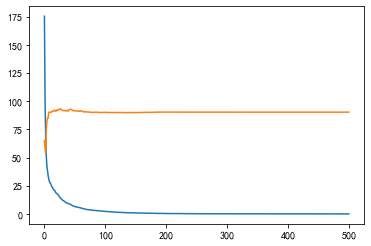

In [119]:
plt.plot(xgbr.evals_result()['validation_0']['rmse'])
plt.plot(xgbr.evals_result()['validation_1']['rmse'])

In [31]:
xgbr.predict(test1_featured).tolist()

[613.1387329101562,
 683.9924926757812,
 630.9996337890625,
 731.9994506835938,
 699.9902954101562,
 707.9913940429688,
 832.0057983398438,
 989.9893188476562,
 781.0258178710938,
 740.9968872070312,
 769.9917602539062,
 778.9999389648438,
 992.9788208007812,
 1111.00244140625,
 1121.9918212890625,
 1093.0023193359375,
 976.0048828125,
 962.0076904296875,
 898.9766235351562,
 1031.9971923828125,
 927.9888305664062,
 582.022705078125,
 333.96405029296875,
 479.0312805175781,
 558.0118408203125,
 543.997314453125,
 541.0055541992188,
 563.0023803710938,
 287.99224853515625,
 243.01199340820312,
 287.00628662109375,
 263.9804992675781,
 371.00579833984375,
 381.9969177246094,
 250.0021209716797,
 235.98403930664062,
 230.02059936523438,
 192.98597717285156,
 183.02322387695312,
 195.9720458984375,
 166.01133728027344,
 187.98353576660156,
 187.0291290283203,
 173.9622039794922,
 81.00865936279297,
 208.97442626953125,
 202.02586364746094,
 183.9940643310547,
 175.01585388183594,
 218.9610

NameError: name 'y_valid' is not defined

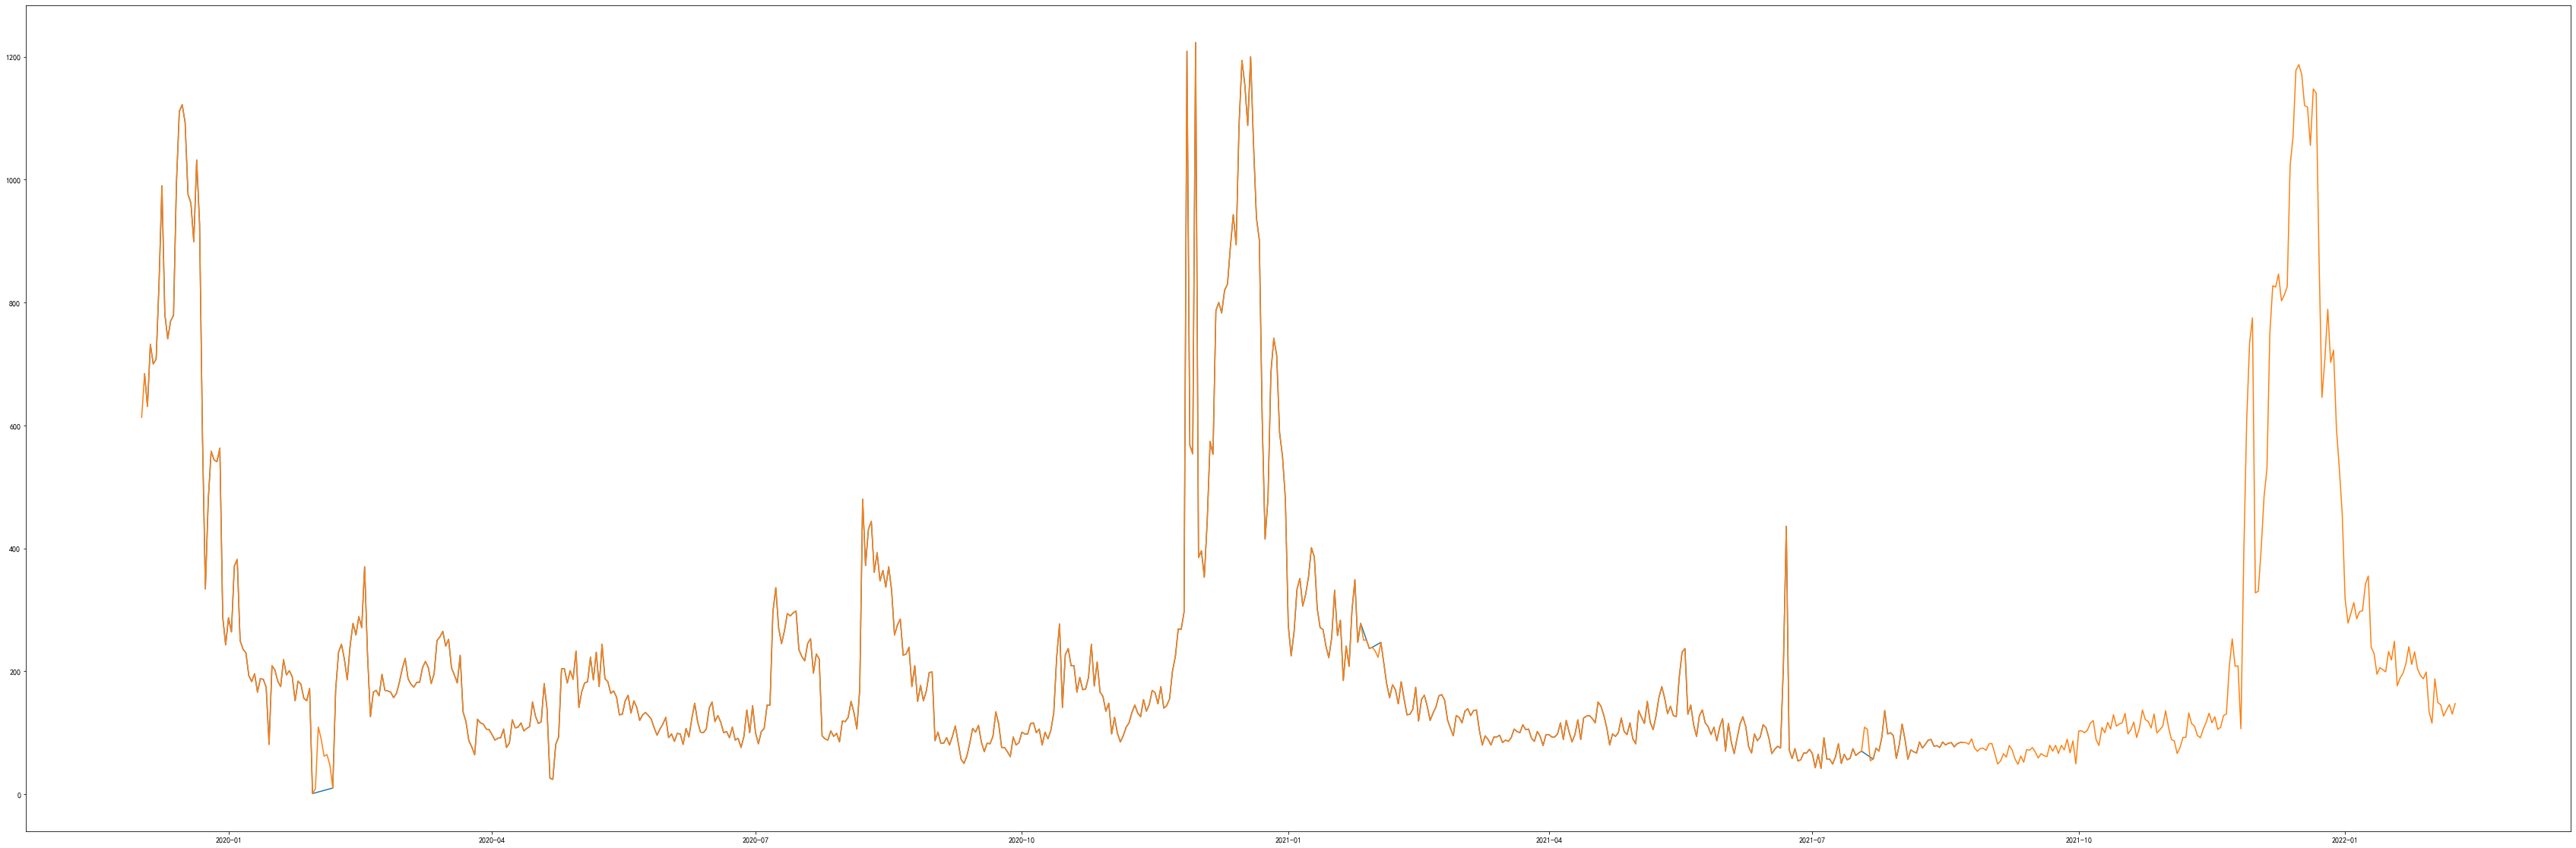

In [30]:
predict_days = 800
test1 = pd.DataFrame(
    {'data_date': pd.date_range('2019-12-02', periods=predict_days)})
test1_featured = create_feature(test1)
# test1_enc = onehot.transform(test1_featured)
plt.figure(figsize=(60, 20))
plt.plot(train.data_date, train.ordered_units, label='train')
plt.plot(test1.data_date, xgbr.predict(test1_featured), label='train_predict')
plt.plot(y_valid.index, y_valid, label='true valid')
plt.plot(y_valid.index, y_pred, label='prediction')
plt.legend()
plt.grid()

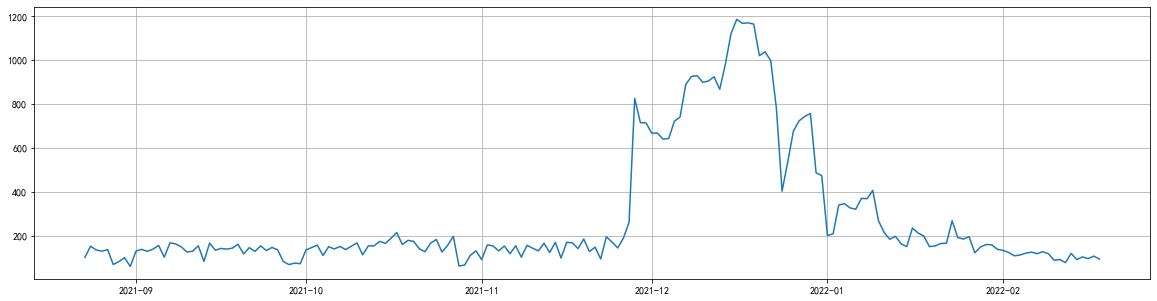

In [121]:
predict_days = 180
test1 = pd.DataFrame(
    {'data_date': pd.date_range('2021-08-23', periods=predict_days)})
test1_featured = create_feature(test1)
# test1_enc = onehot.transform(test1_featured)
plt.figure(figsize=(20, 5))
plt.plot(test1.data_date, xgbr.predict(test1_featured))
plt.grid()

In [7]:
xgbr.predict(test1_featured)

NameError: name 'xgbr' is not defined

In [37]:
if not os.path.exists('model'):
    os.makedirs('model')

In [43]:
save_path = os.path.join('model', asin)
joblib.dump(xgbr, save_path+'.pkl')

['model\\B07FKN76ZS.pkl']

In [39]:
xgbr_load = joblib.load(save_path)

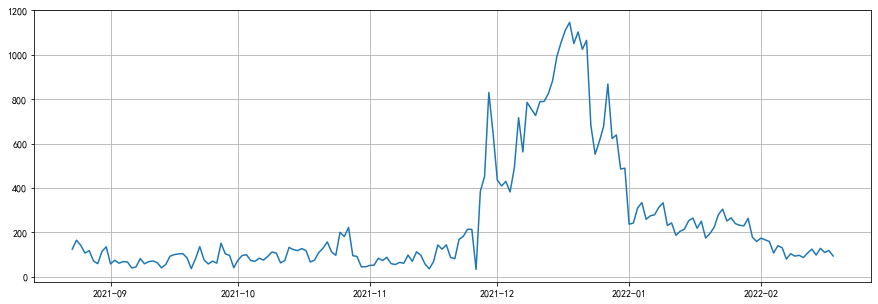

In [42]:
predict_days = 180
test1 = pd.DataFrame(
    {'data_date': pd.date_range('2021-08-23', periods=predict_days)})
test1_featured = create_feature(test1)
# test1_enc = onehot.transform(test1_featured)
plt.figure(figsize=(15, 5))
plt.plot(test1.data_date, xgbr_load.predict(test1_featured))
plt.grid()

## 深度学习方法

In [1]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

oh_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
alldata = pd.concat([train_featured, test_featured])


def split_dataset(alldata, is_encode, encoder, test_size):

    x_train, x_test, y_train, y_test = train_test_split(alldata.drop(
        'ordered_units', axis=1).values, alldata.ordered_units.values, test_size=test_size, shuffle=False)

    if is_encode:
        x_train = encoder.fit_transform(x_train)
        x_test = encoder.transform(x_test)

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_dataset(alldata, True, scaler1, 0.1)

print(x_train.shape, x_test.shape)
# print(x_train[0][:5])

dataset = torch.utils.data.TensorDataset(
    torch.Tensor(x_train), torch.Tensor(scaler2.fit_transform(y_train.reshape(-1, 1))))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)

NameError: name 'MinMaxScaler' is not defined

In [458]:
num_hiddens = 200


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(8, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, 1))

    def forward(self, x):
        output = self.main(x)
        return output


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)


net = Net()
net.apply(init_weights)

Net(
  (main): Sequential(
    (0): Linear(in_features=8, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [459]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [460]:
epochs = 200
for epoch in range(epochs):
    for x, y in dataloader:
        out = net(x)
        loss = loss_func(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 20 == 0:
        print(loss)

tensor(0.5021, grad_fn=<MseLossBackward>)
tensor(0.1038, grad_fn=<MseLossBackward>)
tensor(0.0330, grad_fn=<MseLossBackward>)
tensor(0.0164, grad_fn=<MseLossBackward>)
tensor(0.0170, grad_fn=<MseLossBackward>)
tensor(0.0203, grad_fn=<MseLossBackward>)
tensor(0.0249, grad_fn=<MseLossBackward>)
tensor(0.0294, grad_fn=<MseLossBackward>)
tensor(0.0340, grad_fn=<MseLossBackward>)
tensor(0.0364, grad_fn=<MseLossBackward>)


In [461]:
r2_score(y_test, scaler2.inverse_transform(
    net(torch.Tensor(x_test)).detach().numpy()))

-0.7056176370553637

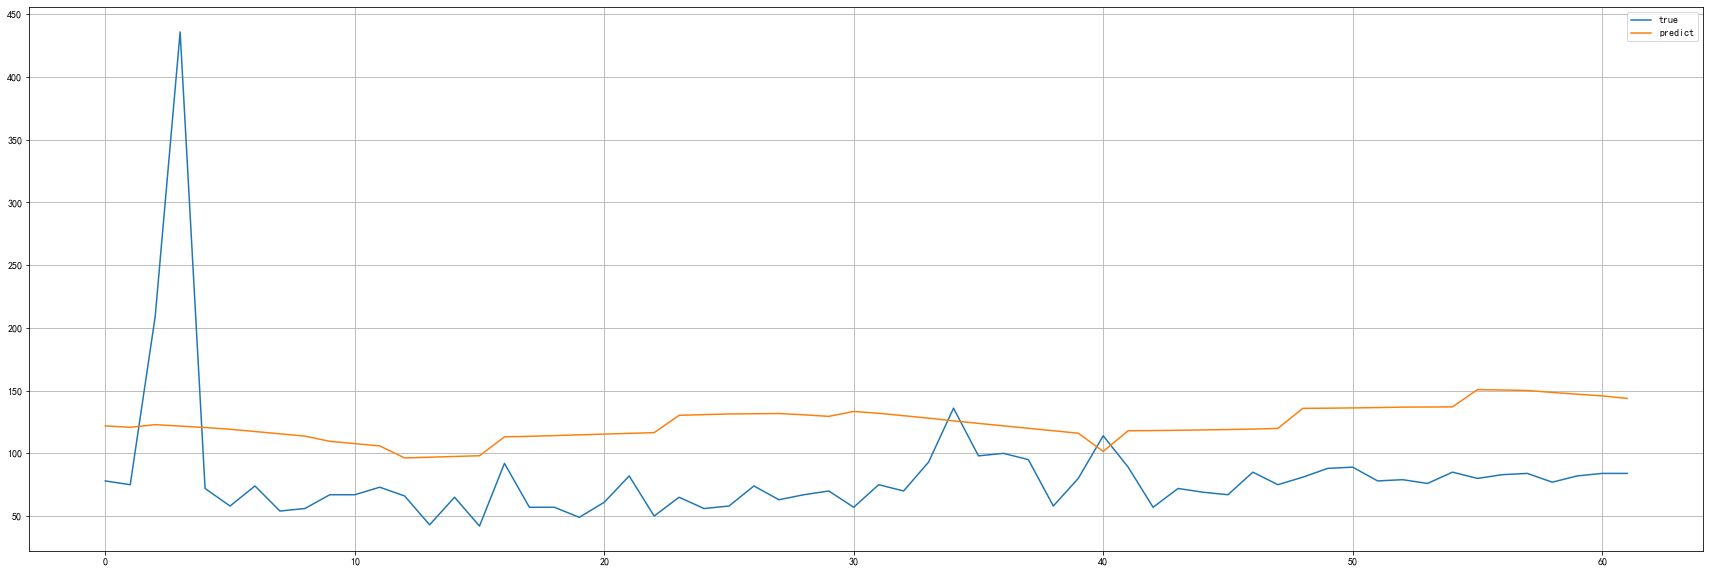

In [462]:
plt.figure(figsize=(30, 10))
plt.plot(y_test, label='true')
plt.plot(scaler2.inverse_transform(
    net(torch.Tensor(x_test)).detach().numpy()), label='predict')
plt.legend()
plt.grid()

## 调整参数

In [170]:
timeKF = TimeSeriesSplit(n_splits=3)
params_dict = {
    'subsample': [0.3, 0.4, 0.5],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'learning_rate': np.arange(0, 0.3, 0.05),
    'max_depth': [3, 4, 5, 6, ],
    'gamma': [1.2, 1.3, 1.4, 1.5],
    'min_child_weight': [5, 6, 7]}
gridscv = GridSearchCV(xgbr, params_dict, cv=timeKF,
                       scoring='r2', n_jobs=8, verbose=1)

In [171]:
gridscv.fit(x_train, y_train)

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1.0, gamma=1.4, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=6,
                                    missing=nan, mo...
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=0.3,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=1),
             n_jobs=8,
   

In [172]:
gridscv.best_params_, gridscv.best_score_

({'colsample_bytree': 1,
  'gamma': 1.5,
  'learning_rate': 0.25,
  'max_depth': 6,
  'min_child_weight': 5,
  'subsample': 0.3},
 -1.0942733437244143)

In [164]:
gridscv.cv_results_

{'mean_fit_time': array([1.33286707, 1.22643288, 1.22111877, 1.42769392, 1.35479736,
        1.30528704, 1.21026103, 1.24637699, 1.41820868, 1.29453754,
        1.55358092, 1.56811515, 1.44427276, 1.1715521 , 1.08327134,
        1.09965014, 1.08910974, 1.0772899 , 1.01927948, 0.81322432]),
 'std_fit_time': array([0.21329068, 0.17997205, 0.26413621, 0.06497255, 0.11091995,
        0.06990695, 0.104627  , 0.09581668, 0.10179805, 0.1271405 ,
        0.10366   , 0.04944711, 0.04512301, 0.06301198, 0.07754169,
        0.05698187, 0.05217522, 0.07370435, 0.04917995, 0.02632781]),
 'mean_score_time': array([0.01732032, 0.01914541, 0.0088714 , 0.00455777, 0.00488337,
        0.00507164, 0.00756327, 0.00644803, 0.00579572, 0.00461332,
        0.00424075, 0.00527946, 0.00464153, 0.00451756, 0.00495211,
        0.00484848, 0.00398723, 0.00431975, 0.00419362, 0.00400575]),
 'std_score_time': array([0.01843786, 0.01710207, 0.00493793, 0.00047258, 0.00069126,
        0.00100341, 0.00472042, 0.001952

In [296]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(
    metrics1(y_test, y_pred),
    metrics2(y_test, y_pred),
    r2_score(y_test, y_pred)))

metrics1: 0.678
metrics2: 0.376
r2: -1.420


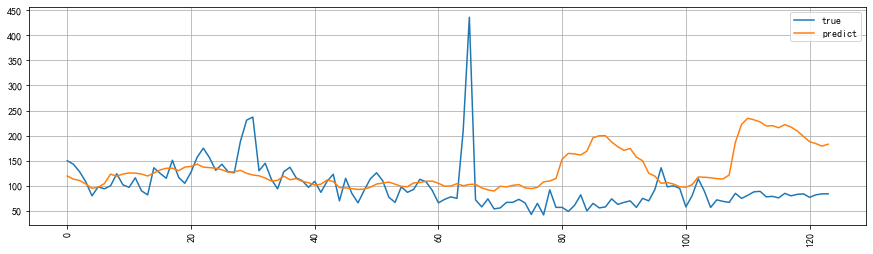

In [297]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

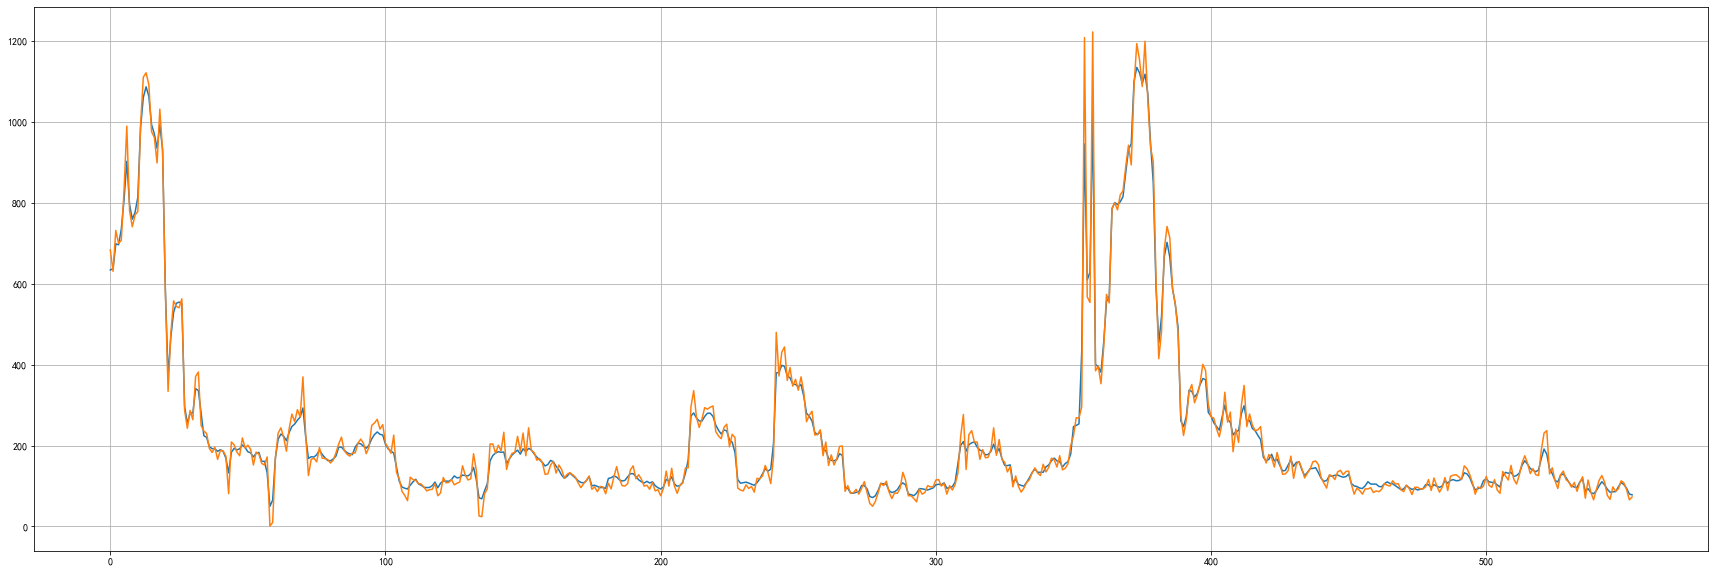

In [292]:
plt.figure(figsize=(30, 10))
plt.plot(xgbr.predict(x_train))
plt.plot(y_train.values)
plt.grid()